# Background

The MBTA community law requires a by-right zone of 15 units per acre. There are sources of images of different density levels online, but it's hard to understand in the abstract without a local example to understand. This should answer the question 'what does this level of density look like in my community?'

In [99]:
# data i/o
from dvc.api import DVCFileSystem
from io import BytesIO
from zipfile import ZipFile
from dbfread import DBF

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import mplcursors

# processing
import geopandas as geo_pd
import pandas as pd
import numpy as np

# misc
from tqdm import tqdm_pandas
from tqdm.auto import tqdm

from math import pi, sqrt

%matplotlib inline

fs = DVCFileSystem("https://github.com/tjrileywisc/waltham_etl")

tqdm.pandas()

In [11]:
with fs.open("data/gis/L3_SHP_M308_WALTHAM.zip") as f:
    content = BytesIO(f.read())
    zip = ZipFile(content)
    zip.extractall("../../data/gis")
    property_shapefiles_df = geo_pd.read_file("../../data/gis/L3_SHP_M308_WALTHAM/M308TaxPar_CY22_FY23.shp")
    property_shapefiles_df['centroid'] = property_shapefiles_df['geometry'].apply(lambda x: x.centroid)
    
    assessments_table = DBF("../../data/gis/L3_SHP_M308_WALTHAM/M308Assess_CY22_FY23.dbf", load=True)
    assessments_df = pd.DataFrame([dict(r) for r in assessments_table.records])
    
    def home_style(x):
        if int(x) == 101:
            return "SFH"
        elif int(x) > 102 and int(x) <= 112:
            return "MFH"
    
        return "OTHER OR NON HOME"

property_shapefiles_df.head() 

,SHAPE_Leng,SHAPE_Area,MAP_PAR_ID,LOC_ID,POLY_TYPE,MAP_NO,SOURCE,PLAN_ID,LAST_EDIT,BND_CHK,NO_MATCH,TOWN_ID,geometry,centroid
0,106.284365,416.922636,R079 001 0038,F_720118_2954451,FEE,079,ASSESS,NaN,20111130,OK,N,308,"POLYGON ((219510.406 900516.563, 219505.564 90...",POINT (219492.454 900518.533)
1,124.114669,875.162824,R079 001 0036,F_720144_2954524,FEE,079,ASSESS,NaN,20111130,OK,N,308,"POLYGON ((219521.229 900544.743, 219512.577 90...",POINT (219500.236 900540.754)
2,89.087299,415.368750,R080 002 0014,F_722474_2954539,FEE,080,ASSESS,NaN,20111130,OK,N,308,"POLYGON ((220212.276 900527.633, 220199.657 90...",POINT (220210.372 900545.361)
3,190.134403,1076.273990,R079 001 0037,F_720055_2954540,FEE,079,ASSESS,NaN,20111130,OK,N,308,"POLYGON ((219481.807 900560.359, 219483.941 90...",POINT (219473.170 900545.465)
4,102.019748,615.329243,R079 001 0033,F_720183_2954604,FEE,079,ASSESS,NaN,20111130,OK,N,308,"POLYGON ((219530.434 900568.770, 219524.316 90...",POINT (219512.264 900565.209)


In [12]:
assessments_df.head()

,PROP_ID,LOC_ID,BLDG_VAL,LAND_VAL,OTHER_VAL,TOTAL_VAL,FY,LOT_SIZE,LS_DATE,LS_PRICE,...,YEAR_BUILT,BLD_AREA,UNITS,RES_AREA,STYLE,STORIES,NUM_ROOMS,LOT_UNITS,CAMA_ID,TOWN_ID
0,R063 002 0017,F_734012_2963106,257400,392000,7300,656700,2023,0.11,20080930,385000,...,1930,1352,1,1352,COLONIAL,2,6,A,28,308
1,R015 004 0001,F_730830_2973583,236500,388900,0,625400,2023,0.22,20080422,1,...,1962,1931,1,1931,RANCH,1,5,A,46,308
2,R015 003 0017,F_730659_2973534,171600,382200,5200,559000,2023,0.21,19770301,39500,...,1952,1756,1,1756,CONVENTIONAL,2,7,A,55,308
3,R015 005 0001,F_730718_2973342,400200,391900,6100,798200,2023,0.23,20061205,1,...,1952,2922,1,2922,COLONIAL,2,6,A,64,308
4,R015 006 0006,F_730548_2973294,369300,382600,2700,754600,2023,0.21,20050315,1,...,1952,1792,1,1792,COLONIAL,2,8,A,73,308


In [37]:
properties_df = property_shapefiles_df.merge(assessments_df, left_on=["MAP_PAR_ID", "LOC_ID", "TOWN_ID"], right_on=["PROP_ID", "LOC_ID", "TOWN_ID"], how="inner")
properties_df.head()

,SHAPE_Leng,SHAPE_Area,MAP_PAR_ID,LOC_ID,POLY_TYPE,MAP_NO,SOURCE,PLAN_ID,LAST_EDIT,BND_CHK,...,ZONING,YEAR_BUILT,BLD_AREA,UNITS,RES_AREA,STYLE,STORIES,NUM_ROOMS,LOT_UNITS,CAMA_ID
0,106.284365,416.922636,R079 001 0038,F_720118_2954451,FEE,079,ASSESS,NaN,20111130,OK,...,,1975,1612,1,1612,COLONIAL,2,5,A,138167
1,124.114669,875.162824,R079 001 0036,F_720144_2954524,FEE,079,ASSESS,NaN,20111130,OK,...,,1860,5678,2,5678,TWO FAMILY,3,17,A,138185
2,89.087299,415.368750,R080 002 0014,F_722474_2954539,FEE,080,ASSESS,NaN,20111130,OK,...,,0,0,0,0,,,0,A,35492
3,190.134403,1076.273990,R079 001 0037,F_720055_2954540,FEE,079,ASSESS,NaN,20111130,OK,...,,1975,960,1,960,RANCH,1,5,A,138176
4,102.019748,615.329243,R079 001 0033,F_720183_2954604,FEE,079,ASSESS,NaN,20111130,OK,...,,1960,1517,1,1517,COLONIAL,2,7,A,137809


In [9]:
# find the radius - we want 1 acre in the unit of the CRS,
# which is apparently in meters (https://www.mass.gov/info-details/overview-of-massgis-data)

AREA = 4046.86 # 1 acre in m^2

radius = sqrt(AREA / pi)

print(radius)  # radius of the circle to draw around each parcel centroid, in meters

35.89088388437564


In [40]:
# TODO:
# we really need neighboring communities to get this calculation right,
# since they do have a local effect

def calc_local_density(row):

    parcel_buffer = row["centroid"].buffer(radius)

    neighbors = properties_df["centroid"].intersection(parcel_buffer)
    
    return properties_df[~neighbors.is_empty]["UNITS"].sum()

properties_df["LOCAL_DENSITY"] = properties_df.progress_apply(lambda row: calc_local_density(row), axis = 1)

#properties_df.at[0, "LOCAL_DENSITY"] = properties_df[~neighbors.is_empty]["UNITS"].sum()

#roperties_df[~neighbors.is_empty].plot()

  0%|          | 0/13318 [00:00<?, ?it/s]

In [45]:
properties_df[properties_df["LOCAL_DENSITY"] == properties_df["LOCAL_DENSITY"].max()]

,SHAPE_Leng,SHAPE_Area,MAP_PAR_ID,LOC_ID,POLY_TYPE,MAP_NO,SOURCE,PLAN_ID,LAST_EDIT,BND_CHK,...,YEAR_BUILT,BLD_AREA,UNITS,RES_AREA,STYLE,STORIES,NUM_ROOMS,LOT_UNITS,CAMA_ID,LOCAL_DENSITY
12088,2013.856836,145851.338231,R014 007 0029,F_727116_2974092,FEE,014,ASSESS,NaN,20111130,OK,...,1972,776099,730,776099,APARTMENTS,3,279,A,65805,730


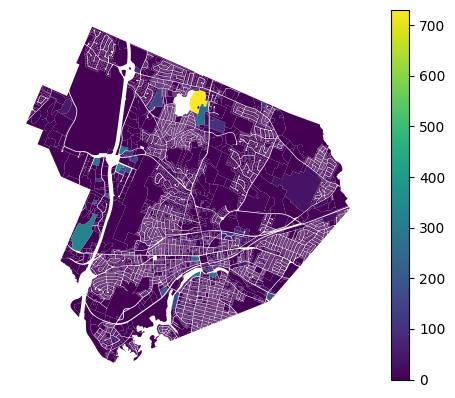

In [103]:
ax = properties_df.plot(column="LOCAL_DENSITY", legend=True)

ax.set_axis_off()

# TODO
# show density value on hover,
# or something to remove outliers

<Axes: xlabel='LOCAL_DENSITY', ylabel='Count'>

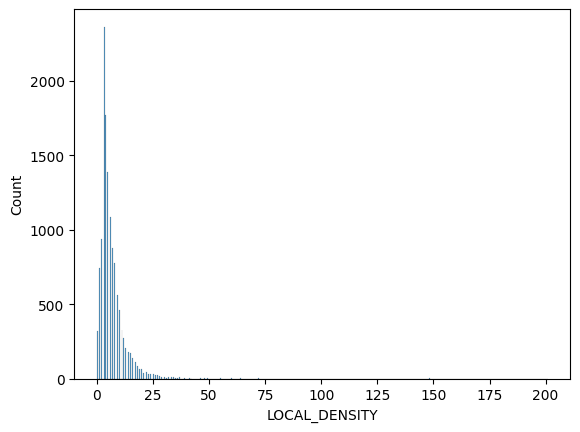

In [118]:
sns.histplot(data=properties_df[properties_df["LOCAL_DENSITY"] < 240], x="LOCAL_DENSITY", kde=False)

In [116]:
np.histogram(properties_df[properties_df["LOCAL_DENSITY"] < 240]["LOCAL_DENSITY"])

(array([12910,   331,    34,    10,     2,     8,     3,     5,     1,
            5], dtype=int64),
 array([  0. ,  20.1,  40.2,  60.3,  80.4, 100.5, 120.6, 140.7, 160.8,
        180.9, 201. ]))

In [122]:
# parcels w/ >= 15 local density
meets_density_count = len(properties_df[properties_df["LOCAL_DENSITY"] >= 15])

# remainder
low_density_count = len(properties_df[properties_df["LOCAL_DENSITY"] < 15])

print(f"{low_density_count} / {len(properties_df)} are low density")
print(f"{meets_density_count} / {len(properties_df)} meet the minimum MBTA density (citywide)")

12269 / 13318 are low density
1049 / 13318 meet the minimum MBTA density (citywide)


In [124]:
# household unit counts in each group
meets_density_unit_count = properties_df[properties_df["LOCAL_DENSITY"] >= 15]["UNITS"].sum()

# remainder
low_density_unit_count = properties_df[properties_df["LOCAL_DENSITY"] < 15]["UNITS"].sum()

total_units = properties_df["UNITS"].sum()

print(f"{low_density_unit_count} / {total_units} unit counts in low density")
print(f"{meets_density_unit_count} / {total_units} unit counts in minimum MBTA density (citywide)")

15382 / 27755 unit counts in low density
12373 / 27755 unit counts in minimum MBTA density (citywide)
